In [1]:
!pip3 install pmdarima

In [2]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import date, timedelta
import pmdarima as pm

In [3]:
raw = pd.read_csv("peanuts.csv")
pn = pd.DataFrame(columns=["price"], index=pd.to_datetime(raw.date), data=raw.price.values)
raw = pd.read_csv("BrentOil.csv")
bc = pd.DataFrame(columns=["price"], index=pd.to_datetime(raw.date), data=raw.price.values)
bc = bc[pn.index[0]-timedelta(days=1):pn.index[-1]]
bc.reset_index(inplace=True)
pn.reset_index(inplace=True)

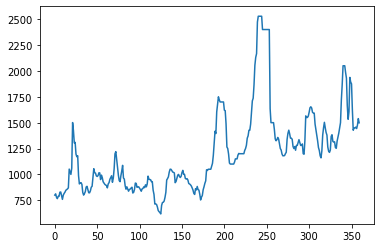

In [4]:
plt.plot(pn.price)

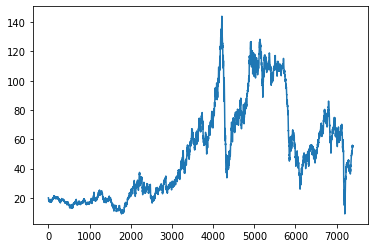

In [5]:
plt.plot(bc.price)

In [6]:
oil = []
peanut = []
date = pd.date_range(bc.date[0],pn.date[359],freq='d')
for i in date:
  if i in list(pn.date):
    peanut.append(pn.loc[pn["date"]==i].price.values[0])
  else:
    peanut.append(peanut[-1])
  if i in list(bc.date):
    oil.append(bc.loc[bc["date"]==i].price.values[0])
  else:
    oil.append(oil[-1])
df = pd.DataFrame()
df['peanut'] = peanut
df['oil'] = oil
df.index = date
df.to_csv("commodities.csv")
ndf = (df-df.mean())/df.std()

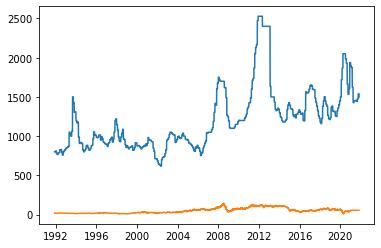

In [7]:
plt.plot(df.peanut)
plt.plot(df.oil)

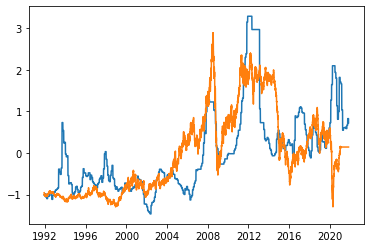

In [8]:
plt.plot(ndf.peanut)
plt.plot(ndf.oil)

In [9]:
df

,peanut,oil
1991-12-01,800.00,20.08
1991-12-02,800.00,19.60
1991-12-03,800.00,19.20
1991-12-04,800.00,19.18
1991-12-05,800.00,19.15
...,...,...
2021-10-28,1539.29,55.44
2021-10-29,1539.29,55.44
2021-10-30,1539.29,55.44
2021-10-31,1539.29,55.44


In [45]:
timeseries = df["peanut"][0:8000]
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel
def plotarima(n_periods, timeseries, automodel):
    # Forecast
    fc, confint = automodel.predict(n_periods=n_periods, return_conf_int=True)
    # Weekly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], periods=n_periods, freq="D")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries)
    plt.plot(fc_series, color="red")
    plt.xlabel("date")
    plt.ylabel(timeseries.name)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", alpha=.25)
    plt.plot(df.peanut[timeseries.shape[0]:timeseries.shape[0] + n_periods])
    plt.legend(("past", "forecast", "actual", "95% confidence interval"), loc="upper left")
    plt.show()

In [46]:
automodel = arimamodel(timeseries)
automodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=64932.551, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=64928.551, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=64930.551, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=64930.551, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=64926.734, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.167 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8000
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -32462.367
Date:                Tue, 04 Jan 2022   AIC                          64926.734
Time:                        20:41:43   BIC                          64933.721
Sample:                             0   HQIC                         64929.125
                               - 8000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       196.0960      0.121   1614.545      0.000     195.858     196.334
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):         564917888.49
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.28   Skew:                           -15.02
Prob(H) (two-sided):                  0.00   Kurtosis:                      1304.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

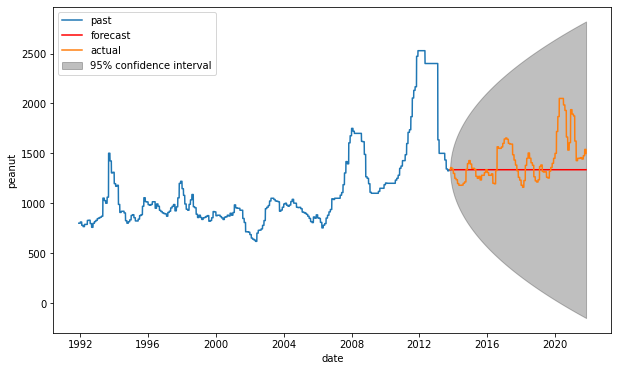

In [51]:
plotarima(2929, timeseries, automodel)